### ***Joseph Leandre Derpo 63110107***

#### ***MNIST 14-layered CNN model with 99% accuracy***

In [69]:
# Libraries 
%reset 
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Flatten,Dropout

# Settin random seed to obtain the same results
np.random.seed(3632)
random.seed(3632)
tf.random.set_seed(3632)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [70]:
# preparation of MNIST dataset

# parameters of MNIST dataset
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28 X 28 = 784)

# import and load MNIST data, split between and test datasets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert pixel values to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# normalize image pixcel values from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

# data should be 4D so setting gray scale color channel is necessary to make it work with Conv2D
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

# check shape of MNIST dataset
print('MNIST Dataset Shapes:')
print(f'x_train: {str(x_train.shape)}')
print(f'y_train: {str(y_train.shape)}')
print(f'x_test: {str(x_test.shape)}')
print(f'y_test: {str(y_test.shape)}')

# determine the shape of the input images
inp_shape = x_train.shape[1:]
print(f'Image Dimension: {inp_shape}')

MNIST Dataset Shapes:
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)
Image Dimension: (28, 28, 1)


In [71]:
# training parameters
learning_rate = 0.1
training_epochs = 2000
batch_size = 256
display_step = 100

In [72]:
# network parameters
n_hidden_1 = 32 # 1st hidden layer number of neurons
n_hidden_2 = 64 # 2nd hidden layer number of neurons
n_hidden_3 = 128 # 3nd hidden layer number of neurons

In [73]:
# use tf.data API to shuffle and batch data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [74]:
# MNIST CNN architecture
class ConvNeuralNetwork(Model):

    # set layers
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()

        self.model = Sequential()

        # first CNN layer
        self.model.add(layers.Conv2D(n_hidden_1, (3,3), activation = tf.nn.relu, kernel_initializer='he_uniform'))
        self.model.add(layers.BatchNormalization()) # normalize the input layer as well as hidden layers by adjusting mean and scaling of the activations
        self.model.add(layers.MaxPool2D(2,2)) # downsample data to half to make it faster
        self.model.add(layers.Dropout(0.5)) # dropout to make the model less rely on weight to prevent overfitting
        
        # second CNN layer
        self.model.add(layers.Conv2D(n_hidden_2, (3,3), activation=tf.nn.relu, kernel_initializer='he_uniform'))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.MaxPool2D((2,2)))
        self.model.add(layers.Dropout(0.5))

        # third CNN layer
        self.model.add(layers.Conv2D(n_hidden_3, (3,3), activation=tf.nn.relu, kernel_initializer='he_uniform'))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Dropout(0.5))

        self.model.add(layers.Flatten())  # flatten features into a single column
        self.model.add(layers.Dense(units = 64, activation=tf.nn.relu))

        # output layer
        self.model.add(layers.Dense(units = num_classes)) # combine to 10 classes
    
    # set forward pass
    def call(self, x, is_training = False):    
        
        x = self.model(x)

        if not is_training:
            
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            tf.nn.softmax(x)
        return x

In [75]:
# build convolutional neural network model
c_neural_net = ConvNeuralNetwork()

In [76]:
# initialize variables with Xavier uniform
shape = (num_features, num_classes)
initializer = tf.initializers.GlorotUniform()
trainable_variables = tf.Variable(initializer(shape = shape))

In [77]:
# Cross-Entropy loss - applies 'softmax' to the logits 
def cross_entropy_loss(x, y):
    
  # convert labels to int 64 for tf cross-entropy function
  y = tf.cast(y, tf.int64)
    
  # apply softmax to logits and compute cross-entropy
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = x)
    
  # average loss across the batch
  return tf.reduce_mean(loss)

In [78]:
# accuracy metric
def accuracy(y_pred, y_true):
    
  # predicted class is the index of highest score in prediction vector (i.e. argmax)
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [79]:
# Stochastic gradient descent optimizer

optimizer = tf.keras.optimizers.SGD(learning_rate)

# set up an optimization (forward propagation and back propagation) process 
def run_optimization(x, y):
    
  # wrap computation inside a GradientTape for automatic differentiation
  with tf.GradientTape() as g:
        
      # forward pass
      pred = c_neural_net(x, is_training = True)
        
      # compute loss
      loss = cross_entropy_loss(pred, y)
        
  # variables to update, i.e. trainable variables
  trainable_variables = c_neural_net.trainable_variables

  # compute gradients
  gradients = g.gradient(loss, trainable_variables)
    
  # apply the gradients to update 𝜃 and 𝜃_0  
  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [80]:
# run training for the given number of steps
for step, (batch_x, batch_y) in enumerate(train_data.take(training_epochs), 1):
  run_optimization(batch_x, batch_y)

  if step % display_step == 0:
    pred = c_neural_net(batch_x, is_training = True)
    loss = cross_entropy_loss(pred, batch_y)
    acc = accuracy(pred, batch_y)
    print("step: %i, loss: %f, accuracy: %f" % (step,loss,acc))

pred = c_neural_net(x_test, is_training = False)
print("Test Accuracy:%f" % accuracy(pred,y_test))

step: 100, loss: 0.087886, accuracy: 0.976562
step: 200, loss: 0.101792, accuracy: 0.972656
step: 300, loss: 0.030348, accuracy: 0.992188
step: 400, loss: 0.034139, accuracy: 0.996094
step: 500, loss: 0.033693, accuracy: 0.992188
step: 600, loss: 0.047705, accuracy: 0.988281
step: 700, loss: 0.012480, accuracy: 1.000000
step: 800, loss: 0.021395, accuracy: 0.992188
step: 900, loss: 0.046927, accuracy: 0.980469
step: 1000, loss: 0.011004, accuracy: 0.996094
step: 1100, loss: 0.010681, accuracy: 1.000000
step: 1200, loss: 0.003783, accuracy: 1.000000
step: 1300, loss: 0.017030, accuracy: 0.996094
step: 1400, loss: 0.014743, accuracy: 0.992188
step: 1500, loss: 0.015837, accuracy: 0.992188
step: 1600, loss: 0.004155, accuracy: 1.000000
step: 1700, loss: 0.011605, accuracy: 0.996094
step: 1800, loss: 0.015401, accuracy: 0.992188
step: 1900, loss: 0.008604, accuracy: 1.000000
step: 2000, loss: 0.003159, accuracy: 1.000000
Test Accuracy:0.990000


1/1 [==============================] - 0s 89ms/step
Prediction: 1


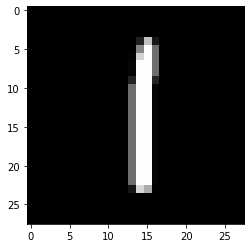

In [81]:
# testing out the model to predict 
img = x_test[random.randint(0, 10000)]
plt.imshow(np.squeeze(img), cmap='gray')

img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
pred_val = c_neural_net.predict(img)
print("Prediction:",np.argmax(pred_val))

In [82]:
# cnn model summary 
c_neural_net.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 11, 11, 64)      